# Sin Wave

## Loading Packages

In [1]:
from Foresight import *
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample

set_seed(42)

True

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'

if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
    
    if torch.cuda.device_count() > 1:
        print("Parallel Available")
        parallel=True
        
    else:
        parallel=False
        
else:
    print("No GPU available!")
    parallel=False

No GPU available!


## Generating Data

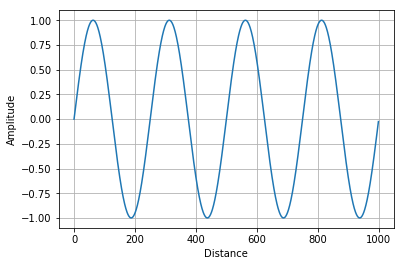

In [3]:
frequency = 4
sample_rate = 1000
x = np.arange(sample_rate)
y = np.sin(2 * np.pi * frequency * x / sample_rate)
plt.plot(x, y)
plt.xlabel('Distance')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [4]:
forecast_length = 5
data_X = y[:-forecast_length].reshape(len(y[:-forecast_length]), 1)
data_y = y[forecast_length:].reshape(len(y[:-forecast_length]), 1)

### Slicing Series into Windows

In [5]:
# The input size of each time series window
series_length = 100
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (895, 100, 1) 
Data y shape (895, 1)


### Hyperparameters

In [6]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 10000
patience = 50
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = 1
dropout = 0.0

### Initialising the model

In [7]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

if parallel:
    model = nn.DataParallel(model)
    print("Parallel Workflow\n")
    
model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 1 
hidden_dim 8
series_length 100 
batch_size 32
output_dim 1 
num_layers 1
data_X  (895, 100, 1) 
data_y (895, 1)


In [8]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=100,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=10)

# Splitting the data into the train, validation and test sets
learning.train_val_test()

### Training

Epoch: 0 Train: 16.33067 Val: 14.70007  Time: 1.020  Best Val: 14.70007


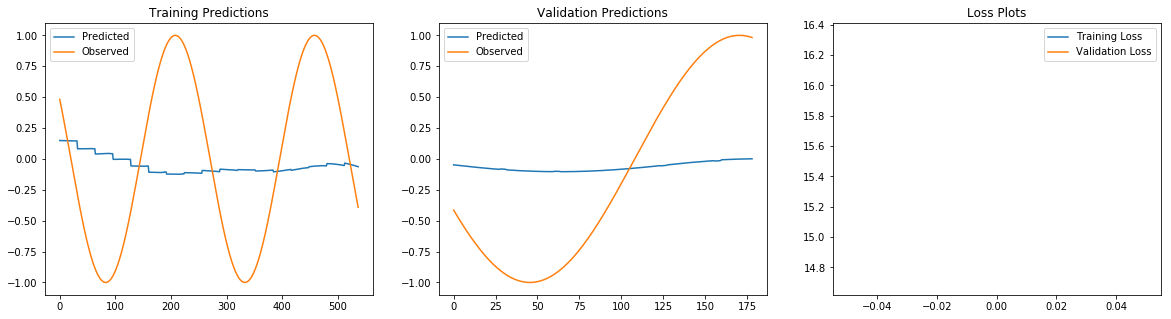

Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3

KeyboardInterrupt: 

In [9]:
# Allows for continious training by resetting the patience counter
# learning.n_epochs = 50
learning.early.stop = False
learning.early.counter = 0
learning.training_wrapper()

### Evaluating the Test Data

In [10]:
learning.evaluate(learning.best_model, learning.test_loader)

7.744542334998786

### Plotting

In [11]:
# Observed
train_true = learning.y_train.numpy()
val_true  = learning.y_val.numpy()
test_true  = learning.y_test.numpy()

# Predicted
train_pred = np.array(learning.train_predictions)
val_pred  = np.array(learning.val_predictions)
test_pred = np.array(learning.test_predictions)

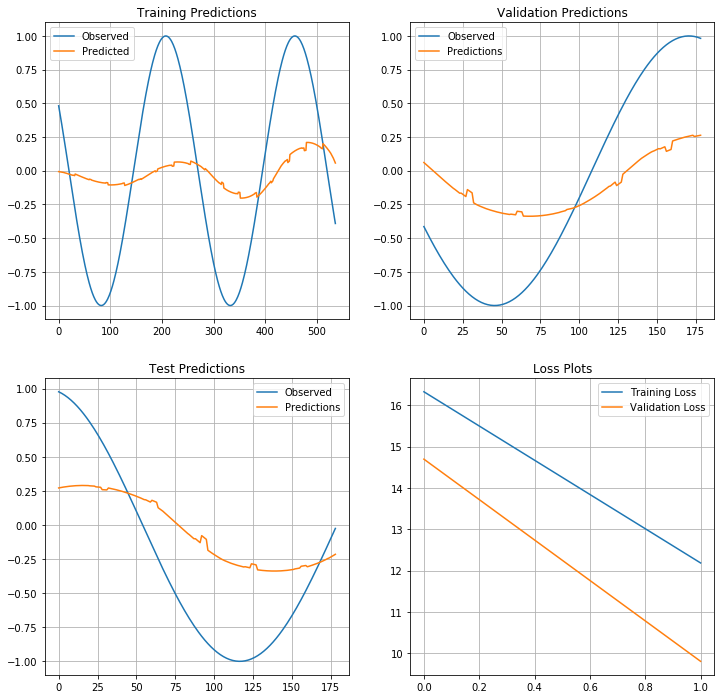

In [12]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

plt.show()

# Results

In [13]:
mse, mae, mda = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mda)

Price Metrics:  0.24250832655464247 0.4362754591079897 0.7752808988764045


### Naive Benchmark

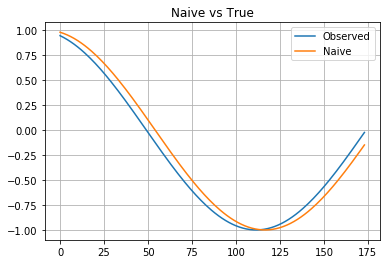

In [15]:
naive_pred = test_true[:-forecast_length]

plt.plot(test_true[forecast_length:] ,label="Observed")
plt.plot(naive_pred, label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
plt.show()

### Metrics for benchmarks

In [16]:
mse_naive, mae_naive, mda_naive = evaluate(naive_pred, test_true[forecast_length:], log_ret=False)
print("naive",
    mse_naive, mae_naive, mda_naive)

naive 0.008203945 0.08299057 0.9653179190751445


In [17]:
print("For Mean Squared Error:")

if mse_naive < mse:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Absolute Error:")

if mae_naive < mae:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Directional Accuracy:")

if mda_naive > mda:
    print("Naive Wins")
else:
    print("LSTM Wins")

For Mean Squared Error:
Naive Wins
For Mean Absolute Error:
Naive Wins
For Mean Directional Accuracy:
Naive Wins


# Autoregressive Signal

## Generating Data

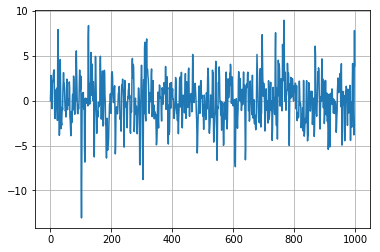

In [18]:
nobs = 1000
ar = [1, -0.5, 0.1]
ma = [1, 0.7]
dist = lambda n: np.random.standard_t(3, size=n)
# np.random.seed(8659567)
y = arma_generate_sample(ar, ma, nobs, sigma=1, distrvs=dist,
                         burnin=500)

y = y.reshape(len(y), 1)

plt.grid()
plt.plot(y)

### Split into train and target

In [19]:
forecast_length = 5
data_X = y[:-forecast_length].reshape(len(y[:-forecast_length]), 1)
data_y = y[forecast_length:].reshape(len(y[:-forecast_length]), 1)

### Chunking Data

In [20]:
series_length = 100
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (895, 100, 1) 
Data y shape (895, 1)


### Hyperparameters

In [21]:
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 10000
patience = 50
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = 1
dropout = 0.1

In [22]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

if parallel:
    model = nn.DataParallel(model)
    print("Parallel Workflow\n")
    
model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 1 
hidden_dim 8
series_length 100 
batch_size 32
output_dim 1 
num_layers 1
data_X  (895, 100, 1) 
data_y (895, 1)


In [23]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=2000,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=200)

# Splitting the data into the train, validation and test sets
learning.train_val_test()

Epoch: 0 Train: 186.96487 Val: 189.39077  Time: 1.146  Best Val: 189.39077


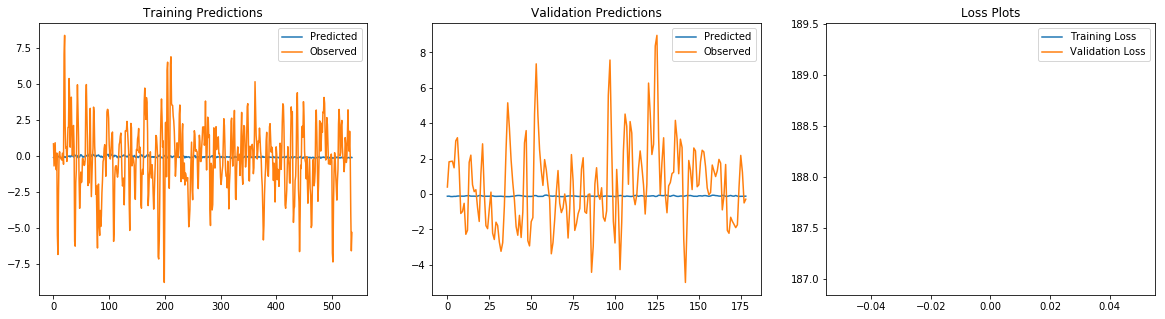

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + 

KeyboardInterrupt: 

In [24]:
# Allows for continious training by resetting the patience counter
learning.n_epochs = 10
learning.early.stop = False
learning.early.counter = 0
learning.training_wrapper()

### Evaluating on best model

In [25]:
learning.evaluate(learning.best_model, learning.test_loader)

150.34717751614875

In [26]:
# Observed
train_true = learning.y_train.numpy()
val_true  = learning.y_val.numpy()
test_true  = learning.y_test.numpy()

# Predicted
train_pred = np.array(learning.train_predictions)
val_pred  = np.array(learning.val_predictions)
test_pred = np.array(learning.test_predictions)

### Plotting

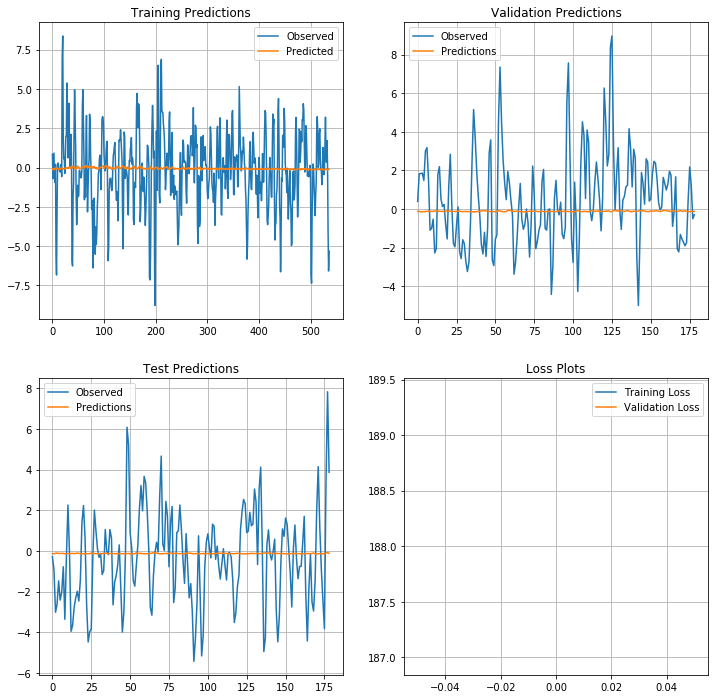

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

plt.show()

In [28]:
mse, mae, mda = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mda)

Price Metrics:  5.105402574146018 1.7528113375870542 0.47191011235955055


### Comparing to benchmark

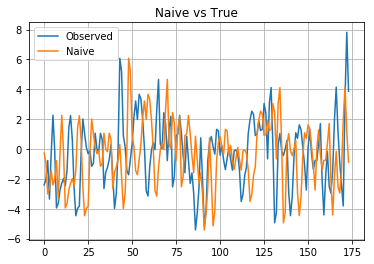

In [29]:
naive_pred = test_true[:-forecast_length]

plt.plot(test_true[forecast_length:] ,label="Observed")
plt.plot(naive_pred, label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
plt.show()

In [32]:
mse_naive, mae_naive, mda_naive = evaluate(naive_pred, test_true[forecast_length:], log_ret=False)
print("naive",
    mse_naive, mae_naive, mda_naive)

naive 9.550411 2.4605935 0.44508670520231214


In [33]:
print("For Mean Squared Error:")

if mse_naive < mse:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Absolute Error:")

if mae_naive < mae:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Directional Accuracy:")

if mda_naive > mda:
    print("Naive Wins")
else:
    print("LSTM Wins")

For Mean Squared Error:
LSTM Wins
For Mean Absolute Error:
LSTM Wins
For Mean Directional Accuracy:
LSTM Wins


### ARMA Regressor Benchmark

In [34]:
train = y[:800]
test = y[800:]

arma = ARMA(train, (3, 2)).fit()
arma_preds = arma.predict(start=1, end=200)

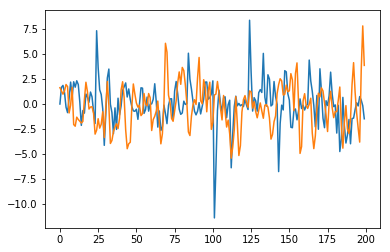

In [70]:
plt.plot(arma_preds)
plt.plot(test)
plt.grid()
plt.show()

In [71]:
arma_preds = arma_preds.reshape(200, 1)

In [72]:
mse_arma, mae_arma, mda_arma = evaluate(arma_preds, test, log_ret=False)
print("ARMA", mse_arma, mae_arma, mda_arma)

ARMA 9.613619283763871 2.3167586190276097 0.507537688442211


In [73]:
print("For Mean Squared Error:")

if mse_arma < mse:
    print("ARMA Wins")
else:
    print("LSTM Wins")
    
print("For Mean Absolute Error:")

if mae_arma < mae:
    print("ARMA Wins")
else:
    print("LSTM Wins")
    
print("For Mean Directional Accuracy:")

if mda_arma > mda:
    print("ARMA Wins")
else:
    print("LSTM Wins")

For Mean Squared Error:
LSTM Wins
For Mean Absolute Error:
LSTM Wins
For Mean Directional Accuracy:
LSTM Wins
